# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.


# 1. Подготовка данных

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


df=pd.read_csv('/datasets/Churn.csv')
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Заменим пропуски на 0 - маловероятно, что клиент банка решит скрывать недвижимость, скорее всего ее нет.

In [98]:
df['Tenure'] = df['Tenure'].fillna(0)
df.isna().mean()

RowNumber          0.0
CustomerId         0.0
Surname            0.0
CreditScore        0.0
Geography          0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

Данные с фамилией, дублем индекса датафрейма и случайный номер не должны повлиять на наш анализ - избавимся от лишних столбцов.

In [99]:
df = df.drop(['RowNumber','CustomerId','Surname'], axis=1)
df.shape

(10000, 11)

# 2. Исследование задачи

Преобразуем категоральные признаки в численные

In [100]:
ohe_df = pd.get_dummies(df, drop_first=True)
ohe_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
CreditScore          10000 non-null int64
Age                  10000 non-null int64
Tenure               10000 non-null float64
Balance              10000 non-null float64
NumOfProducts        10000 non-null int64
HasCrCard            10000 non-null int64
IsActiveMember       10000 non-null int64
EstimatedSalary      10000 non-null float64
Exited               10000 non-null int64
Geography_Germany    10000 non-null uint8
Geography_Spain      10000 non-null uint8
Gender_Male          10000 non-null uint8
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


Исходя из стандартной пропорции 3:1:1 разобъем для начала на обучающую и валидационную, в пропорции 60/40.
Валидационную выборку разобъем пополам, на валидационную и тестовую

In [101]:
target = ohe_df['Exited']
features = ohe_df.drop('Exited', axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(features, target, train_size=0.6, random_state=27)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, 
                                                                            random_state=27)
print(features_train.shape, features_valid.shape, features_test.shape)
print(target_train.shape, target_valid.shape, target_test.shape)

(6000, 11) (2000, 11) (2000, 11)
(6000,) (2000,) (2000,)


Стандартизируем данные

numeric=['CreditScore','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary']
scaler=StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric]=scaler.transform(features_train[numeric])
features_valid[numeric]=scaler.transform(features_valid[numeric])
pd.options.mode.chained_assignment = None

Проверим дисбаланс

In [102]:
target.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Видим дисбаланс - соотношение 1:4.

Будем использовать следующие модели:DecisionTreeClassifier, RandomForestClassifier, LogisticRegression. Рассмотрим, как себя ведет DecisionTreeClassifier и проведем исследование на разное количество деревьев.

In [103]:
%%time

for depth in range(2,12,1):
    model_tree=DecisionTreeClassifier(max_depth=depth,random_state=27).fit(features_train, target_train)
    prediction=model_tree.predict(features_valid)
    probabilities_one_valid = model_tree.predict_proba(features_valid)[:, 1]
    print('max_depth:',depth,'F1:',f1_score(target_valid,prediction))
    print('ROC AUC', roc_auc_score(target_valid, probabilities_one_valid))

max_depth: 2 F1: 0.530446549391069
ROC AUC 0.7602099867724867
max_depth: 3 F1: 0.39436619718309857
ROC AUC 0.8088949121315194
max_depth: 4 F1: 0.436426116838488
ROC AUC 0.8239567094198792
max_depth: 5 F1: 0.613941018766756
ROC AUC 0.8392303535997733
max_depth: 6 F1: 0.533724340175953
ROC AUC 0.8363840761999245
max_depth: 7 F1: 0.5654596100278552
ROC AUC 0.8270126192838246
max_depth: 8 F1: 0.5374823196605375
ROC AUC 0.8028561685090703
max_depth: 9 F1: 0.5691275167785235
ROC AUC 0.8038445412887378
max_depth: 10 F1: 0.5568627450980393
ROC AUC 0.7626967887849584
max_depth: 11 F1: 0.5373891001267427
ROC AUC 0.7382827262849585
CPU times: user 303 ms, sys: 7.9 ms, total: 311 ms
Wall time: 311 ms


Посмотрим на RandomForestClassifier

In [104]:
%%time

for estim in range(1,10,1):
    model_forest=RandomForestClassifier(max_depth=depth,n_estimators=estim,random_state=27).fit(features_train, target_train)
    prediction=model_forest.predict(features_valid)
    probabilities_one_valid = model_forest.predict_proba(features_valid)[:, 1]
    print('estim',estim,'F1:',f1_score(target_valid,prediction))
    print('ROC AUC', roc_auc_score(target_valid, probabilities_one_valid))

estim 1 F1: 0.5313351498637602
ROC AUC 0.7552319538926682
estim 2 F1: 0.48409405255878285
ROC AUC 0.7782391168272864
estim 3 F1: 0.5589041095890411
ROC AUC 0.8038460175736961
estim 4 F1: 0.5454545454545454
ROC AUC 0.8143342840608465
estim 5 F1: 0.566145092460882
ROC AUC 0.8231432764077853
estim 6 F1: 0.5592011412268189
ROC AUC 0.8292956939720333
estim 7 F1: 0.575070821529745
ROC AUC 0.8353824168556311
estim 8 F1: 0.5702005730659025
ROC AUC 0.8396791442271353
estim 9 F1: 0.5738880918220947
ROC AUC 0.8416832010582012
CPU times: user 573 ms, sys: 115 µs, total: 573 ms
Wall time: 578 ms


Смотрим на логистическую регрессию 

In [105]:
%%time

model =  LogisticRegression(random_state=27, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
print('F1', f1_score(target_valid, predicted_valid))
print('ROC AUC', roc_auc_score(target_valid, probabilities_one_valid))

F1 0.0
ROC AUC 0.6631885393046106
CPU times: user 92.9 ms, sys: 56.3 ms, total: 149 ms
Wall time: 119 ms


Применяя к трем моделями категоризацию и стандартизацию (без учета дисбаланса) можно сделать вывод, что оптимальной моделью оказалась DecisionTreeClassifier.

# 3. Борьба с дисбалансом

Воспользуемся фукцией upsampling

In [106]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=27)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

Воспользуемся функцией downsampling

In [107]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=27)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=27)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=27)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.4)

Разобьем имеющийся массив на три набора

Обучим наши модели на новых данных и посмотрим на результаты.

In [108]:
features_train = features_upsampled
target_train = target_upsampled

print("Размер обучающей выборки: {}".format(features_train.shape))
print("Размер валидационной выборки: {}".format(features_valid.shape))
print("Размер тестовой выборки: {}".format(features_test.shape))

Размер обучающей выборки: (9672, 11)
Размер валидационной выборки: (2000, 11)
Размер тестовой выборки: (2000, 11)


In [109]:
%%time

model_tree=DecisionTreeClassifier(max_depth=depth,random_state=27).fit(features_upsampled, target_upsampled)
prediction=model_tree.predict(features_valid)
probabilities_one_valid = model_tree.predict_proba(features_valid)[:, 1]
print('max_depth:',depth,'F1:',f1_score(target_valid,prediction))
print('ROC AUC', roc_auc_score(target_valid, probabilities_one_valid))

max_depth: 11 F1: 0.566990291262136
ROC AUC 0.7684476568405141
CPU times: user 54.8 ms, sys: 0 ns, total: 54.8 ms
Wall time: 52.2 ms


In [83]:
%%time

model_tree=DecisionTreeClassifier(max_depth=depth,random_state=27).fit(features_downsampled, target_downsampled)
prediction=model_tree.predict(features_valid)
probabilities_one_valid = model_tree.predict_proba(features_valid)[:, 1]
print('max_depth:',depth,'F1:',f1_score(target_valid,prediction))
print('ROC AUC', roc_auc_score(target_valid, probabilities_one_valid))

max_depth: 11 F1: 0.5395256916996047
ROC AUC 0.7393456514550264
CPU times: user 36.3 ms, sys: 10 µs, total: 36.4 ms
Wall time: 42.9 ms


In [84]:
%%time

model_forest=RandomForestClassifier(max_depth=depth,n_estimators=estim,random_state=27).fit(features_train, target_train)
prediction=model_forest.predict(features_valid)
probabilities_one_valid = model_forest.predict_proba(features_valid)[:, 1]
print('estim',estim,'F1:',f1_score(target_valid,prediction))
print('ROC AUC', roc_auc_score(target_valid, probabilities_one_valid))

estim 9 F1: 0.6222222222222222
ROC AUC 0.8534595261715797
CPU times: user 156 ms, sys: 0 ns, total: 156 ms
Wall time: 155 ms


In [85]:
%%time

model_forest=RandomForestClassifier(max_depth=depth,n_estimators=estim,random_state=27).fit(features_downsampled, target_downsampled)
prediction=model_forest.predict(features_valid)
probabilities_one_valid = model_forest.predict_proba(features_valid)[:, 1]
print('estim',estim,'F1:',f1_score(target_valid,prediction))
print('ROC AUC', roc_auc_score(target_valid, probabilities_one_valid))


estim 9 F1: 0.6018808777429467
ROC AUC 0.8381157584561602
CPU times: user 77.9 ms, sys: 0 ns, total: 77.9 ms
Wall time: 88.1 ms


In [86]:
%%time

model=LogisticRegression(random_state=27, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
print('F1', f1_score(target_valid, predicted_valid))
print('ROC AUC', roc_auc_score(target_valid, probabilities_one_valid))

F1 0.47711927981995494
ROC AUC 0.7339867370559334
CPU times: user 170 ms, sys: 93.1 ms, total: 263 ms
Wall time: 243 ms


In [87]:
%%time

model=LogisticRegression(random_state=27, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
print('F1', f1_score(target_valid, predicted_valid))
print('ROC AUC', roc_auc_score(target_valid, probabilities_one_valid))

F1 0.42840512223515714
ROC AUC 0.7142133763227513
CPU times: user 55.5 ms, sys: 76.2 ms, total: 132 ms
Wall time: 128 ms


Лучше всего себя проявила модель RandomForestClassifier - подберем для нее значения гиперпараметров.

In [88]:
%%time

for max_depth in range(10,20,1):
    model_forest=RandomForestClassifier(max_depth=max_depth,n_estimators=estim,random_state=27)
    model_forest.fit(features_train, target_train)
    prediction=model_forest.predict(features_valid)
    probabilities_one_valid = model_forest.predict_proba(features_valid)[:, 1]
    print('max_depth:',max_depth,'F1:',f1_score(target_valid,prediction))
    print('ROC AUC', roc_auc_score(target_valid, probabilities_one_valid))

max_depth: 10 F1: 0.6072144288577155
ROC AUC 0.8467616213151927
max_depth: 11 F1: 0.6222222222222222
ROC AUC 0.8534595261715797
max_depth: 12 F1: 0.6124604012671594
ROC AUC 0.8510339899848829
max_depth: 13 F1: 0.6226622662266227
ROC AUC 0.8345756271258504
max_depth: 14 F1: 0.6036446469248291
ROC AUC 0.8424427496693122
max_depth: 15 F1: 0.5901262916188289
ROC AUC 0.8224413029100528
max_depth: 16 F1: 0.6139747995418098
ROC AUC 0.8397824841742252
max_depth: 17 F1: 0.586248492159228
ROC AUC 0.8192458841175361
max_depth: 18 F1: 0.5731559854897218
ROC AUC 0.8138995181405896
max_depth: 19 F1: 0.5907473309608541
ROC AUC 0.8239744248393801
CPU times: user 1.65 s, sys: 15.9 ms, total: 1.67 s
Wall time: 1.7 s


In [89]:
%%time

for estim in range(25,35,1):
    model_forest=RandomForestClassifier(max_depth=14,n_estimators=estim,random_state=27)
    model_forest.fit(features_train, target_train)
    prediction=model_forest.predict(features_valid)
    probabilities_one_valid = model_forest.predict_proba(features_valid)[:, 1]
    print('estim',estim,'F1:',f1_score(target_valid,prediction))
    print('ROC AUC', roc_auc_score(target_valid, probabilities_one_valid))

estim 25 F1: 0.6471277842907385
ROC AUC 0.8585342557161754
estim 26 F1: 0.6526806526806528
ROC AUC 0.8601537403155707
estim 27 F1: 0.6448598130841121
ROC AUC 0.860102808484505
estim 28 F1: 0.6494724501758499
ROC AUC 0.8606320566421012
estim 29 F1: 0.6502923976608186
ROC AUC 0.8617090065192743
estim 30 F1: 0.6550522648083622
ROC AUC 0.8614174402399849
estim 31 F1: 0.6582278481012659
ROC AUC 0.8603648490646258
estim 32 F1: 0.6558891454965359
ROC AUC 0.8600467096560847
estim 33 F1: 0.6605080831408776
ROC AUC 0.8605870299508692
estim 34 F1: 0.6511627906976742
ROC AUC 0.8612971230158729
CPU times: user 4.85 s, sys: 30.9 ms, total: 4.88 s
Wall time: 4.93 s


Подобрали значения гиперпараметров - переходим к тестированию модели.

# 4. Тестирование модели

In [95]:
model_forest = RandomForestClassifier(max_depth=14,n_estimators=33,random_state=27)
model_forest.fit(features_train, target_train) 
prediction_test = model_forest.predict(features_test)
prediction_valid = model_forest.predict(features_valid)
probabilities_one_test = model.predict_proba(features_test)[:, 1]
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]

print("Наилучшая модель")
print('F1:',f1_score(target_test, prediction_test ))
print('F1:',f1_score(target_valid, prediction_valid))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=14, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=33,
                       n_jobs=None, oob_score=False, random_state=27, verbose=0,
                       warm_start=False)

Наилучшая модель
F1: 0.618798955613577
F1: 0.6605080831408776


In [ ]:
model_forest = RandomForestClassifier(max_depth=14,n_estimators=33,random_state=27)
model_forest.fit(features_train, target_train) 
prediction_test = model_forest.predict(features_test)
probabilities_one_valid = model.predict_proba(features_test)[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, label='ROC-кривая на тестовой')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show();

Для понимания работы модели посмотрим как она ранжировала признаки по важности.

                   importance
feature                      
Age                     0.262
NumOfProducts           0.145
Balance                 0.138
EstimatedSalary         0.132
CreditScore             0.124
Tenure                  0.073
IsActiveMember          0.040
Geography_Germany       0.032
Gender_Male             0.023
HasCrCard               0.016
Geography_Spain         0.015


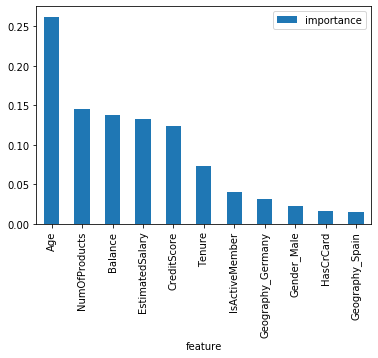

In [94]:
model_forest = RandomForestClassifier(max_depth=14,n_estimators=33,random_state=27)
model_forest.fit(features_train, target_train) 
prediction_test = model_forest.predict(features_test)
probabilities_one_valid = model.predict_proba(features_test)[:, 1]

importances = pd.DataFrame({'feature':features_train.columns,'importance':np.round(model_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
print(importances)
importances.plot.bar();

Выясним как сильно результаты нашей модели отличаются от результатов случайной.

In [93]:
auc_roc = roc_auc_score(target_test, probabilities_one_valid)
print(auc_roc)

0.6891928039569483


Обученная модель случайного леса со взвешенными классами имеет достаточную адекватность, подтвержденная ее значением AUC-ROC. Это лучше, чем случайная модель предсказывания (AUC-ROC = 0.5).
Модель можно рекомендовать для пронозирования оттока на реальных данных.

# Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*